In [1]:
from collections import defaultdict
import numpy as np
from numpy.random import choice
import pandas as pd
from random import random, sample
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sb

from bandit_classes import *

//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def wander(val, delta=0.005, epsilon=0.1):
    if random() < epsilon:
        if random() > 0.5:
            val += delta
        else:
            val -= delta
        if val > 1.0:
            val = 1.0
        elif val < 0:
            val = 0.0
        else:
            pass
    return val

def wander_periodic(val, t, norm=50.0):
    vec[i] = 0.5 + 0.5*sin(t/norm)

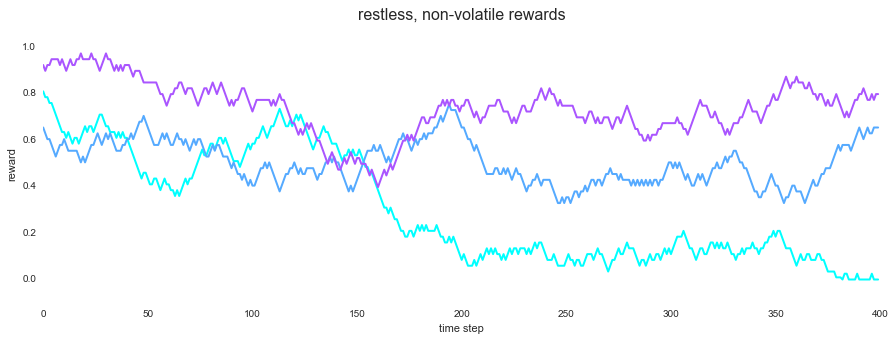

In [3]:
# data like {0:[(t1,v1),(t2,v2),...], 1:[(t1,v1),(t2,v2), ...], ...}
# defaultdict(list(tuples))
def plot_volatile_restless_static_data(data, active, ax=None, 
                            title='volatile, static rewards',
                             colormap=plt.cm.cool):
    if not ax:
        fig, ax = plt.subplots(figsize=(10,4))
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('time step')
    ax.set_ylabel('reward')
    ax.grid('off')
    ax.set_axis_bgcolor('white')
    ax.set_ylim([-0.1, 1.1])
    k = len(data.keys())
    i = 0
    for arm_id, time_val_dict in data.items():
        if colormap:
            color = colormap(float(i)/k)
        else:
            color = 'k'
        xytups = sorted(time_val_dict.items())
        #print(arm_id)
        #print([e[0] for e in xytups])
        xs, ys = zip(*xytups)
        ax.plot(xs, ys, linewidth=2, c=color,  label=str(i)+' actual')
        i += 1
    #ax.legend(loc='best')
    #sb.set_style("white")
    
def gen_volatile_restless_data(k = 10, T = 300, p = 0.01, delta=0.01, epsilon=0.75):
    data = defaultdict()
    active = defaultdict(set)
    n = 0
    for arm_id in range(k):
        data[arm_id] = defaultdict(float)
        data[arm_id][0] = np.random.rand()
        active[0].add(arm_id)
        n += 1
    for t in range(1,T):
        next_active = set([])
        for i in active[t-1]:
            data[i][t] = wander(data[i][t-1], delta, epsilon)
            if random() > p: # stay alive
                next_active.add(i)
            else:
                data[n] = defaultdict(float)
                data[n][t] = np.random.rand()
                next_active.add(n)
                n += 1
        active[t] = next_active
    return data, active

def gen_volatile_restless_beta_data(k = 10, T = 300, p = 0.01, a = 1, b = 10):
    data = defaultdict()
    active = defaultdict(set)
    n = 0
    for arm_id in range(k):
        data[arm_id] = defaultdict(float)
        data[arm_id][0] = np.random.beta(a, b)# stats.beta.rvs(a,b,1)
        active[0].add(arm_id)
        n += 1
    for t in range(1,T):
        next_active = set([])
        for i in active[t-1]:
            data[i][t] = data[i][t-1]
            if random() > p: # stay alive
                next_active.add(i)
            else:
                data[n] = defaultdict(float)
                data[n][t] = np.random.beta(a, b) #stats.beta.rvs(a,b,1)
                next_active.add(n)
                n += 1
        active[t] = next_active
    return data, active

k, T = 3, 400

data, active = gen_volatile_restless_data(k, T, 0, delta=0.025, epsilon=0.75)
#data, active = gen_volatile_restless_beta_data(k, T, a=5,b=5)
#print(data)#, active)
#print(active)
f, ax = plt.subplots(1, figsize=(15,5))
plot_volatile_restless_static_data(data, active, ax=ax, title='restless, non-volatile rewards')
f.savefig('restless_nonvolatile_rewards.png', dpi=100)
#plot_volatile_restless_static_data(data, active)

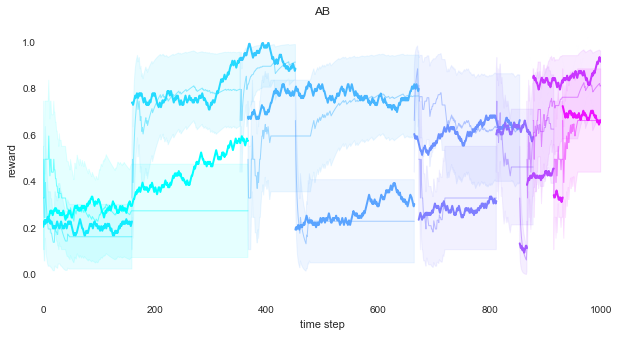

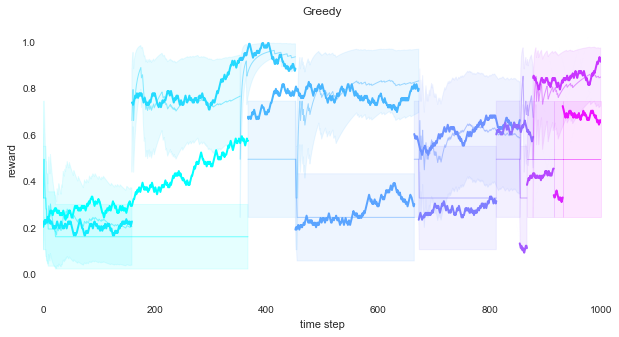

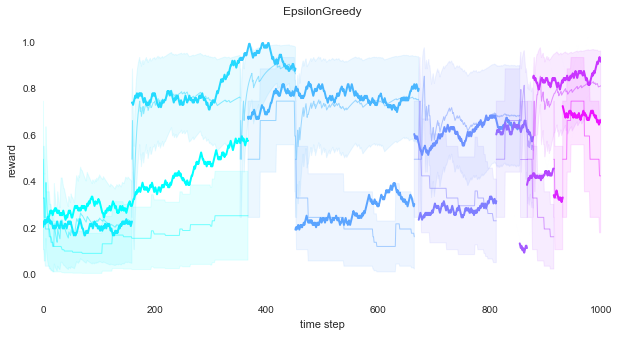

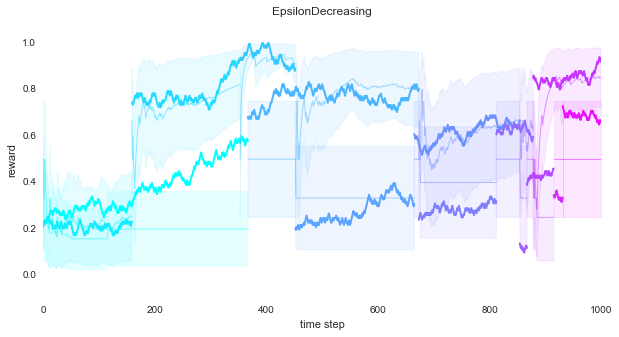

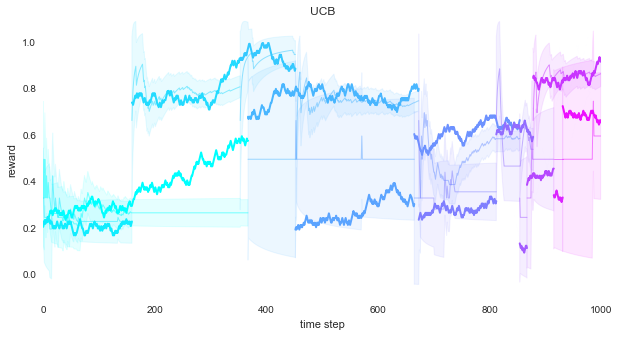

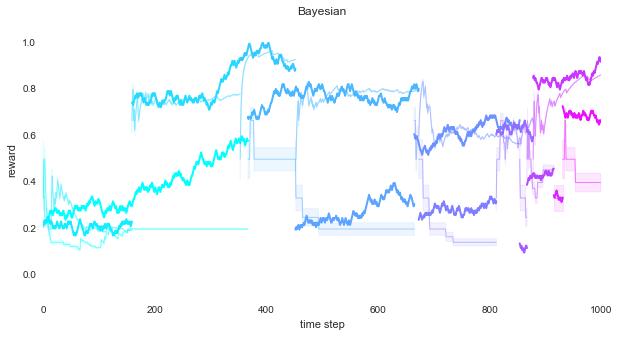

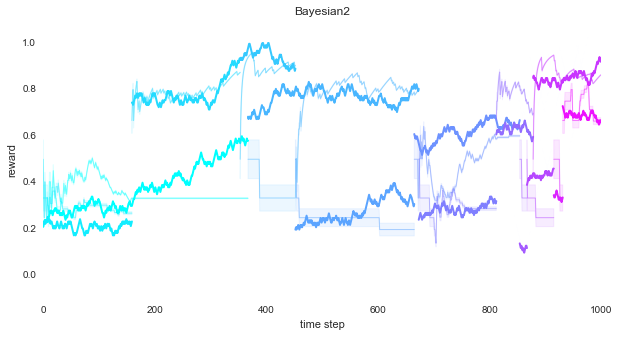

In [4]:
def test_volatile(k = 2, T = 10, 
                data = None,
                active = None,
                bandit = None):
    rewards = np.zeros(T)
    expected_values = defaultdict(list) # key: arm_id, value: [(t1, mean), (t2, mean), ...]
    variances = defaultdict(list)# key: arm_id, value: [(t1, var), (t2, var), ...]
    regret = np.zeros(T)
    for t in range(T):
        if t > 0:
            new_arms = [i for i in active[t] if i not in active[t-1]]
            for arm_id in sorted(new_arms):
                bandit.add_arm(arm_id)
        arm = bandit.choose_arm()
        best = max([data[i][t] for i in active[t]])
        reward = 0.0
        if data[arm][t] > np.random.random():
            reward = 1.0
        rewards[t] = reward
        current_regret = (best - rewards[t]) # instentaneous regret
        if t > 0:
            regret[t] = regret[t-1] + current_regret
        else:
            regret[t] = best - rewards[t]
        bandit.update(arm, reward)
        for arm_id in bandit.arms.keys():
            expected_values[arm_id].append((t,bandit.get_expected_value(arm_id)))
            variances[arm_id].append((t,bandit.get_variance(arm_id)))
        if t > 0:
            dead_arms = [i for i in active[t-1] if i not in active[t]]
            #if len(dead_arms) > 0:
                #print('dead_arms', dead_arms)
            for arm_id in dead_arms:
                bandit.remove_arm(arm_id)

    regret = np.array(regret)
    return rewards, expected_values, variances, regret

def plot_arm_data_plus_actual(expected_values, variances, data, active,
                              #figsize=(15,8.45), 
                              figsize=(10,5),
                              colormap = plt.cm.cool,
                              fig_title='title'):
    fig, ax = plt.subplots(figsize=figsize)
    #max_timestep = int(max([lst[-1][0] for (k,lst) in expected_values.items()])) + 1
    plot_volatile_restless_static_data(data, active, ax=ax)
    
    ax.set_title(fig_title); ax.grid('off')
    ax.set_xlabel('time step'); ax.set_ylabel('reward')
    ax.set_axis_bgcolor('white')
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel('time step'); ax.set_ylabel('reward')
    k = len(expected_values.keys())
    for i, arm_id in enumerate(expected_values.keys()):
        color = colormap(i/float(k))
        xs, means = zip(*expected_values[arm_id])
        means = np.array(means)
        h = ax.plot(xs, means, color=color, alpha=0.5, label=str(i)+' arm', linewidth=1)
        if variances:
            xs, ys = zip(*variances[arm_id])
            ys = np.array(ys)
            ax.fill_between(xs, means+ys, means-ys, color=color, alpha=0.1, linewidth=1)
            #if fig_title == 'UCB':
            #    print(variances)
    #ax.legend(loc='best')
    #fig.savefig('plots/nonvolatile_restless_demo_var_'+fig_title.lower()+'.png')
    fig.savefig('plots/volatile_restless_demo_var_'+fig_title.lower()+'.png')
    
def demo_bandits():
    k, T = 2, 1000
    data, active = gen_volatile_restless_static_data(k, T, 0.005, 0.01, 0.9) # volatile
    #data, active = gen_volatile_restless_static_data(k, T, 0, delta=0.025, epsilon=0.75) #non-volatile
    #data, active = gen_volatile_restless_beta_data(k,T,0.005,1,5)
    bandits = [
        AB(k), 
        Greedy(k),
        EpsilonGreedy(k, 0.1),
        EpsilonDecreasing(k),
        UCB(n_arms=k),
        Bayesian(k),
        Bayesian2(k, C=50)
        ]
    for b in bandits:
        bandit_name = b.__class__.__name__
        #print(bandit_name)
        rewards, expected_values, variances, regret = test_volatile(k, T, data, active, b)
        #print(arm_data)
        #print(expected_values)
        #variances = None
        plot_arm_data_plus_actual(expected_values, variances, data, active, 
                                  fig_title=bandit_name)
        
demo_bandits()

In [ ]:
def do_sims(bandits, n_sims=10, k=3, T=100, data_gen=gen_volatile_restless_static_data, 
            params=None):
    #if data_gen == gen_static_beta:
    #    a, b = params['a'], params['b']
    data, active = gen_volatile_restless_static_data(k, T, 0.01, 0.01, 0.9) # volatile
    #data, active = gen_volatile_restless_static_data(k, T, 0.0, 0.01, 0.9) # non-volatile
    ts = pd.Series(range(T))
    df_final = None
    for sim in range(n_sims):
        for i, bandit in enumerate(bandits):
            bandit = bandit(k)
            rewards, expected_values, variances, regret = test_volatile(k, T, data, active, 
                                                                        bandit)
            rewards = rewards.tolist()
            df = pd.DataFrame(ts, columns=['time'])
            df['policy'] = [bandit.__class__.__name__]*T
            df['regret'] = regret
            df['sim'] = pd.Series([sim]*T)
            if df_final is None:
                df_final = df
            else:
                df_final = pd.concat([df_final, df], ignore_index=True)
    fig, ax = plt.subplots(figsize=(15,8), dpi=100)
    ax.set_title('regret over time, k = '+str(k)+', sims = '+str(n_sims), 
                 fontsize=18)
    sb.set_palette('colorblind')
    sb.set_style("whitegrid")
    sb.tsplot(df_final, time='time', unit='sim', value='regret', 
              condition='policy', 
              ci=1, ax=ax)
    ax.set_xlabel('time step', fontsize=16)
    ax.set_ylabel('regret', fontsize=16)
    #fig.savefig('plots/regret_nonvolatile_restless_'+str(k)+'_'+str(T)+'.png',dpi=100)
    fig.savefig('plots/regret_volatile_restless_'+str(k)+'_'+str(T)+'.png',dpi=100)
    
bandits = [AB, Greedy, EpsilonGreedy, EpsilonDecreasing, UCB, Bayesian, Bayesian2]
#bandits = [AB, Greedy]#, EpsilonGreedy, UCB, Bayesian2]
params = {'a': 2, 'b': 10}
for k in [2, 4, 8, 16]:
    #do_sims(bandits, n_sims=10, k=k, T=100, data_gen=gen_static_uniform)
    do_sims(bandits, 50, k, 500)#, gen_volatile_restless_static_data, params)
